This notebook will write a class that performs PCA and HMM on macro indicators (maybe will have two classes, one for PCA and one for HMM)

In [75]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [76]:
class MacroPCA:
    def __init__(self, data, n_components = None, frequency='M'):
        """
        Initialse the PCA wrapper.
        param: data - dataframe of macroeconomic indicators
        param: n_components - number of principal components to keep (default: all)
        param: frequency - resampling frequency ('M' = monthly, 'Q' = quarterly, 'Y' = yearly)
        """
        self.original_data = data
        self.n_components = n_components
        self.frequency = frequency.upper()
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)
        self.fitted = False

    def standardise(self):
        if self.frequency not in ['M', 'Q', 'Y']:
            raise ValueError("Frequency must be 'M', 'Q', or 'Y'")
        self.data = self.original_data.resample(self.frequency).mean()

        self.data_scaled = self.scaler.fit_transform(self.data)
        return self.data_scaled
    
    def run_pca(self):
        if not hasattr(self, 'data_scaled'):
            raise ValueError("You must call standardize() before run_pca().")
        
        self.components = self.pca.fit_transform(self.data_scaled)
        self.explained_variance = self.pca.explained_variance_ratio_
        self.loadings = pd.DataFrame(self.pca.components_.T,
                                     index=self.data.columns,
                                     columns=[f'PC{i+1}' for i in range(self.pca.n_components_)])
        self.fitted = True
        return pd.DataFrame(self.components,
                             columns=self.loadings.columns,
                             index=self.data.index)
        
    def get_explained_variance(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.explained_variance

    def get_loadings(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.loadings




In [77]:
# Get the macro data
macro_df = pd.read_csv("monthly_macro.csv")
macro_df.set_index('Date', inplace=True)
macro_df.index = pd.to_datetime(macro_df.index)

macro_df = macro_df[macro_df.index >= '1990-01-01']


In [78]:
model = MacroPCA(data=macro_df, n_components=4)
model.standardise()
pc_df = model.run_pca()

# Optional:
print(model.get_explained_variance())
print(model.get_loadings())


[0.44346413 0.18114306 0.13684418 0.09245506]
                       PC1       PC2       PC3       PC4
VIX              -0.177389  0.535876 -0.244452  0.448400
2Y                0.458181  0.280575  0.140574  0.008471
10Y               0.370743  0.344026  0.430815 -0.017367
YieldCurve       -0.351235  0.033261  0.565788 -0.057706
CreditSpread     -0.400851  0.304392 -0.115394  0.204326
FedFundsRate      0.459148  0.270138  0.026473  0.026666
Inflation_YoY     0.143042 -0.339343  0.207414  0.867295
UnemploymentRate -0.307593  0.179755  0.571097 -0.019255
GDP_YoY           0.105900 -0.448954  0.177692  0.014249


C:\Users\User\AppData\Local\Temp\ipykernel_11744\3182530948.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.data = self.original_data.resample(self.frequency).mean()


Ideas for interpretations:
PC1 - Tight monetary conditions/poliy regime. 
PC2 - Risk Sentiment/Financial Stress
PC3 - Yield Curve Steepness + Labur Slack
PC4 - Inflation specific component

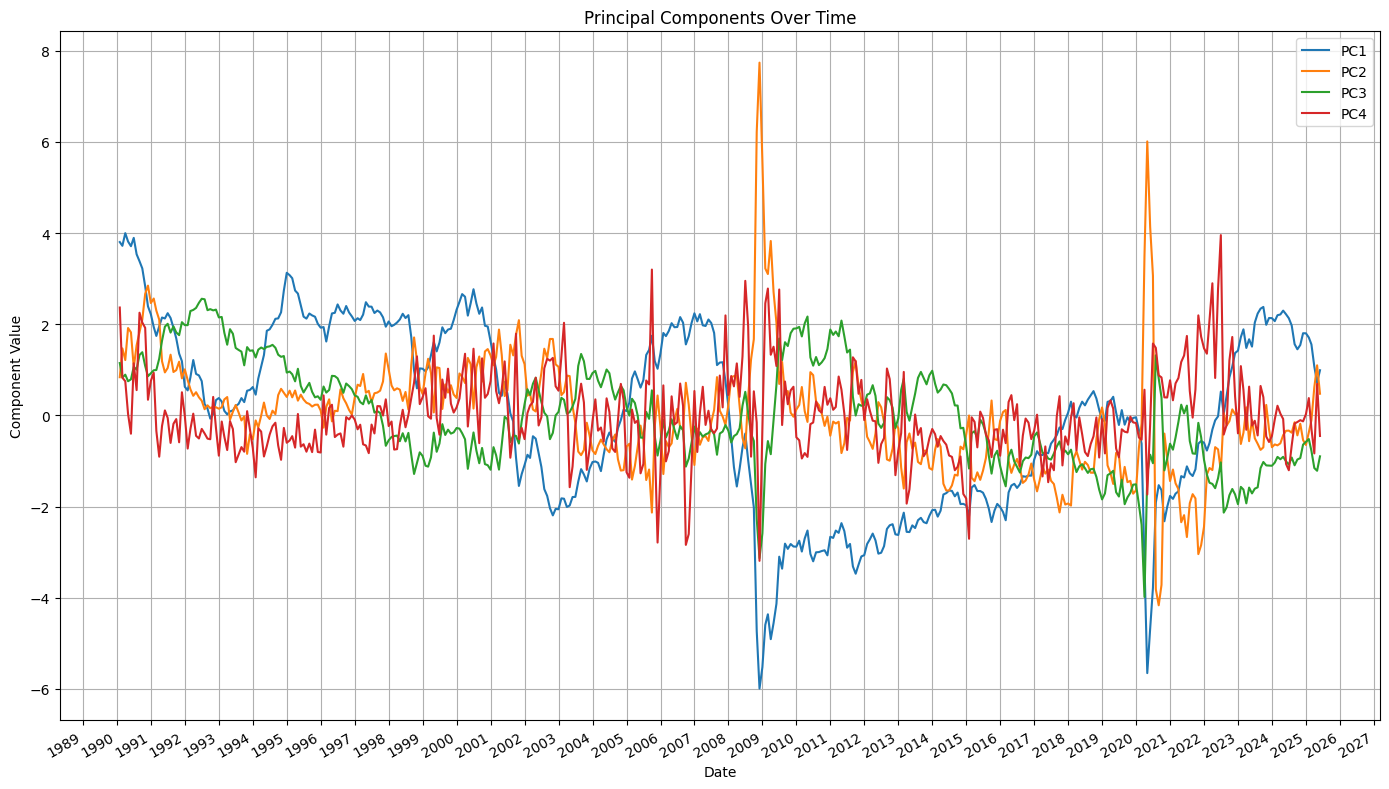

In [79]:
pc_df.index = pd.to_datetime(pc_df.index)

plt.figure(figsize=(14,8))
for i in range(4):
    plt.plot(pc_df.index, pc_df.iloc[:,i], label=f'PC{i+1}')
plt.title('Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Component Value')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for readability

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
from hmmlearn.hmm import GaussianHMM


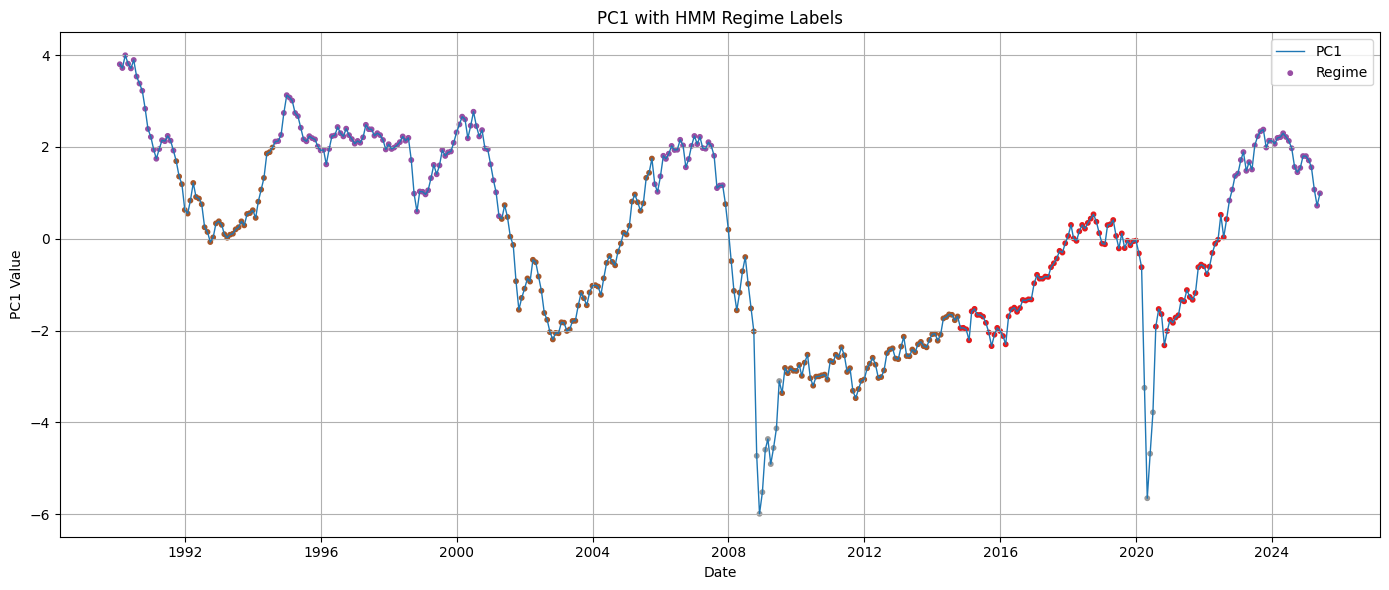

HMM Transition Matrix:
[[0.978 0.011 0.    0.011]
 [0.    0.981 0.019 0.   ]
 [0.006 0.012 0.975 0.006]
 [0.077 0.    0.077 0.846]]


In [81]:
# Use top N principal components
n_regimes = 4  # Assumes there are three latent macro regimes. Assumption based on economic intuition (e.g., expansion, contraction, and transition), but can be varied.

# covariance_type='full' allows each regime to have its own full covariance matrix, capturing correlations among the PCs.


hmm_model = GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=10000, random_state=42)



# Fit the model on the PCA output
hmm_model.fit(pc_df)

# Predict regime labels
regime_labels = hmm_model.predict(pc_df)

# Add regime labels to your DataFrame
pc_df['Regime'] = regime_labels
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pc_df.index, pc_df['PC1'], label='PC1', linewidth=1)

# plt.plot(pc_df.index, pc_df['PC2'], label='PC2', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC3'], label='PC3', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC4'], label='PC4', linewidth=1)

plt.scatter(pc_df.index, pc_df['PC1'], c=pc_df['Regime'], cmap='Set1', label='Regime', s=10)
plt.title('PC1 with HMM Regime Labels')
plt.xlabel('Date')
plt.ylabel('PC1 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("HMM Transition Matrix:")
print(np.round(hmm_model.transmat_, 3))


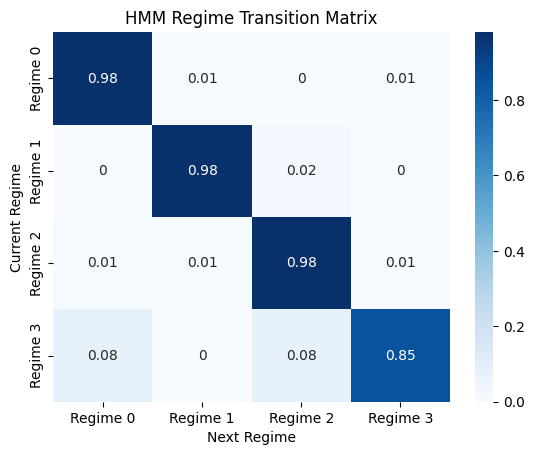

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.heatmap(np.round(hmm_model.transmat_, 2), annot=True, cmap="Blues",
            xticklabels=[f'Regime {i}' for i in range(model.n_components)],
            yticklabels=[f'Regime {i}' for i in range(model.n_components)])
plt.title("HMM Regime Transition Matrix")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()


Now, what if we look at it quarterly?

In [83]:
q_model = MacroPCA(data=macro_df, n_components=4, frequency='Q')
q_model.standardise()
pc_df_q = q_model.run_pca()

print(q_model.get_explained_variance())
print(q_model.get_loadings())


[0.44947535 0.18624591 0.13700203 0.08924214]
                       PC1       PC2       PC3       PC4
VIX              -0.183215  0.528194 -0.222504  0.588583
2Y                0.452212  0.286005  0.147383  0.031351
10Y               0.364874  0.341969  0.438169  0.011466
YieldCurve       -0.350944  0.014778  0.565484 -0.053851
CreditSpread     -0.403793  0.291526 -0.098508  0.281026
FedFundsRate      0.453903  0.277079  0.034350  0.043039
Inflation_YoY     0.172350 -0.358420  0.190973  0.636745
UnemploymentRate -0.307482  0.155662  0.578500 -0.032780
GDP_YoY           0.110977 -0.455627  0.187054  0.402751


C:\Users\User\AppData\Local\Temp\ipykernel_11744\3182530948.py:19: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  self.data = self.original_data.resample(self.frequency).mean()


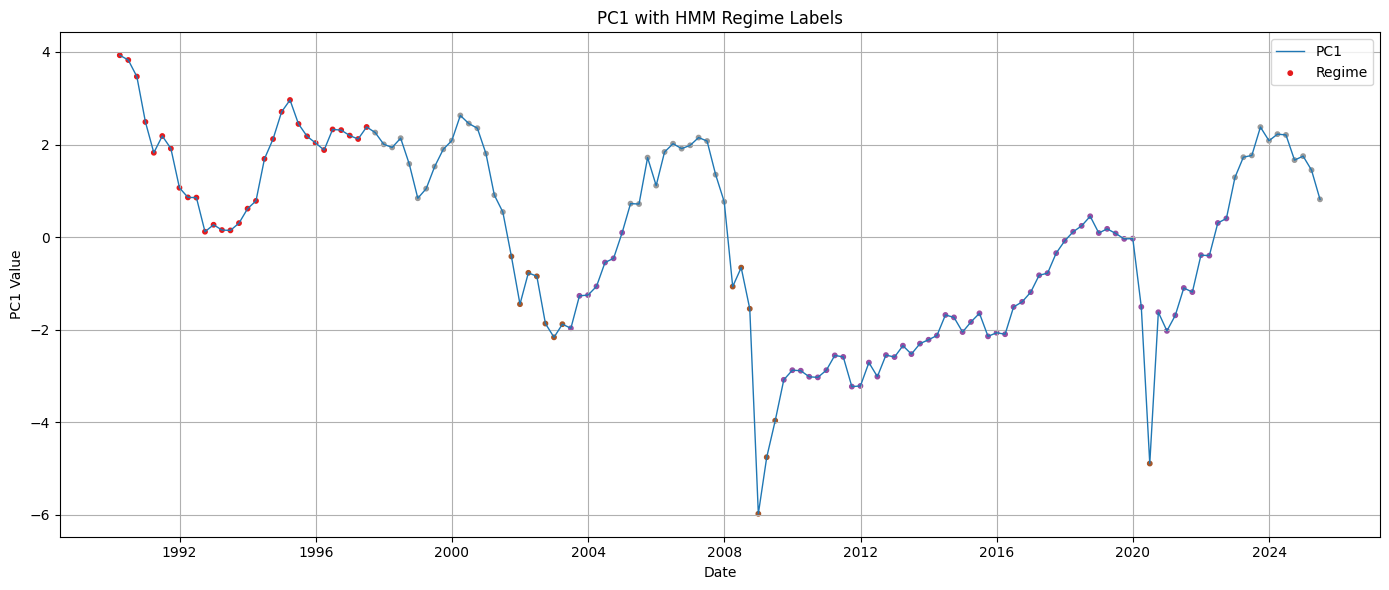

HMM Transition Matrix:
[[0.967 0.    0.    0.033]
 [0.    0.949 0.017 0.034]
 [0.    0.209 0.791 0.   ]
 [0.    0.    0.053 0.947]]


In [84]:
# Use top N principal components
n_regimes = 4  # Assumes there are three latent macro regimes. Assumption based on economic intuition (e.g., expansion, contraction, and transition), but can be varied.

# covariance_type='full' allows each regime to have its own full covariance matrix, capturing correlations among the PCs.


hmm_model = GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=10000, random_state=42)



# Fit the model on the PCA output
hmm_model.fit(pc_df_q)

# Predict regime labels
regime_labels = hmm_model.predict(pc_df_q)

# Add regime labels to your DataFrame
pc_df_q['Regime'] = regime_labels
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pc_df_q.index, pc_df_q['PC1'], label='PC1', linewidth=1)

# plt.plot(pc_df.index, pc_df['PC2'], label='PC2', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC3'], label='PC3', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC4'], label='PC4', linewidth=1)

plt.scatter(pc_df_q.index, pc_df_q['PC1'], c=pc_df_q['Regime'], cmap='Set1', label='Regime', s=10)
plt.title('PC1 with HMM Regime Labels')
plt.xlabel('Date')
plt.ylabel('PC1 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("HMM Transition Matrix:")
print(np.round(hmm_model.transmat_, 3))


now, if we look at it yearly?

In [85]:
y_model = MacroPCA(data=macro_df, n_components=4, frequency='Y')
y_model.standardise()
pc_df_y = y_model.run_pca()

print(y_model.get_explained_variance())
print(y_model.get_loadings())


[0.47433018 0.18408237 0.1374981  0.1000608 ]
                       PC1       PC2       PC3       PC4
VIX              -0.163101  0.548726 -0.275792  0.346789
2Y                0.437906  0.296700  0.143976 -0.064462
10Y               0.348573  0.379578  0.420239 -0.060937
YieldCurve       -0.354362  0.070083  0.544573  0.031495
CreditSpread     -0.415209  0.284711 -0.107924  0.036357
FedFundsRate      0.439879  0.289018  0.029935 -0.102808
Inflation_YoY     0.213817 -0.078535 -0.013349  0.900928
UnemploymentRate -0.310849  0.186155  0.551173  0.136886
GDP_YoY           0.162248 -0.506423  0.336949  0.169045


C:\Users\User\AppData\Local\Temp\ipykernel_11744\3182530948.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.data = self.original_data.resample(self.frequency).mean()


Model is not converging.  Current: -155.29116743370446 is not greater than -129.5696387339931. Delta is -25.72152869971137


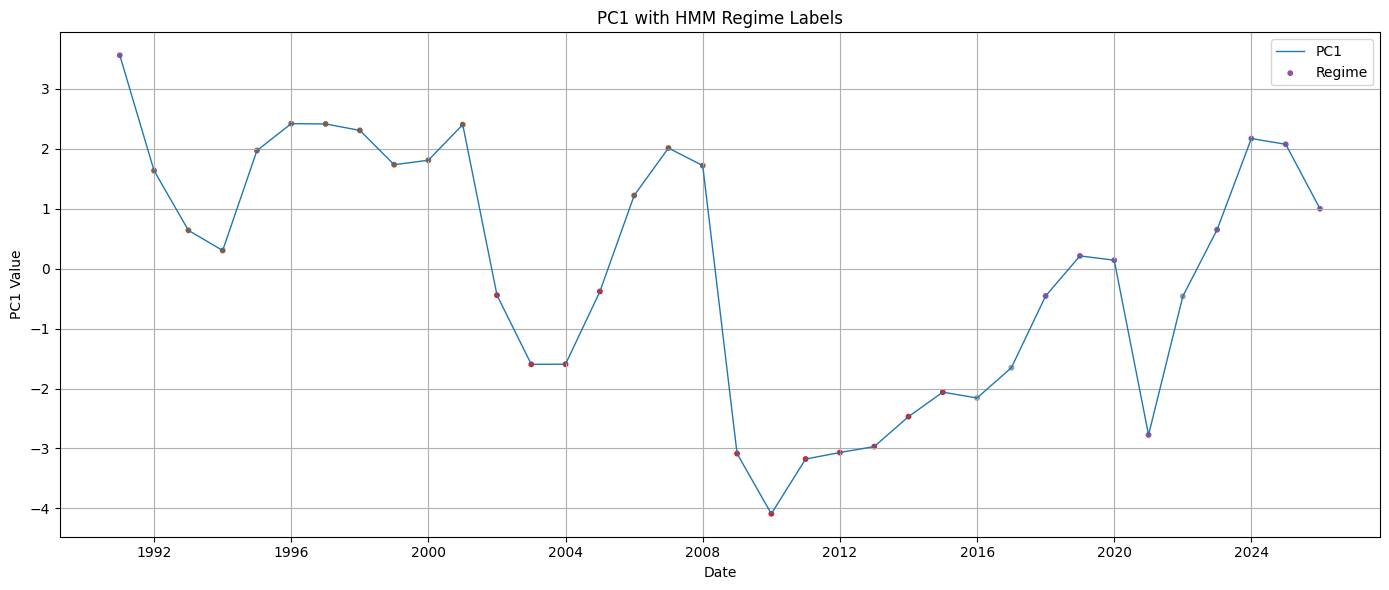

HMM Transition Matrix:
[[0.812 0.    0.094 0.094]
 [0.    0.749 0.126 0.125]
 [0.15  0.    0.85  0.   ]
 [0.    0.667 0.    0.333]]


In [86]:
# Use top N principal components
n_regimes = 4  # Assumes there are three latent macro regimes. Assumption based on economic intuition (e.g., expansion, contraction, and transition), but can be varied.

# covariance_type='full' allows each regime to have its own full covariance matrix, capturing correlations among the PCs.


hmm_model = GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=10000, random_state=42)



# Fit the model on the PCA output
hmm_model.fit(pc_df_y)

# Predict regime labels
regime_labels = hmm_model.predict(pc_df_y)

# Add regime labels to your DataFrame
pc_df_y['Regime'] = regime_labels
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pc_df_y.index, pc_df_y['PC1'], label='PC1', linewidth=1)

# plt.plot(pc_df.index, pc_df['PC2'], label='PC2', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC3'], label='PC3', linewidth=1)
# plt.plot(pc_df.index, pc_df['PC4'], label='PC4', linewidth=1)

plt.scatter(pc_df_y.index, pc_df_y['PC1'], c=pc_df_y['Regime'], cmap='Set1', label='Regime', s=10)
plt.title('PC1 with HMM Regime Labels')
plt.xlabel('Date')
plt.ylabel('PC1 Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("HMM Transition Matrix:")
print(np.round(hmm_model.transmat_, 3))


This next section is about comparisons

In [92]:
# Explained variance for each fequency
m_ex_var = model.get_explained_variance()
q_ex_var = q_model.get_explained_variance()
y_ex_var = y_model.get_explained_variance()

explained_variance_df = pd.DataFrame({
    "Frequency": ['Monthly', 'Quarterly', 'Yearly'],
    'PC1' : [m_ex_var[0], q_ex_var[0], y_ex_var[0]],
    'PC2': [m_ex_var[1], q_ex_var[1], y_ex_var[1]],
    'PC3': [m_ex_var[2], q_ex_var[2], y_ex_var[2]],
    'PC4': [m_ex_var[3], q_ex_var[3], y_ex_var[3]],
    'Cumulative Variance': [m_ex_var.sum(), q_ex_var.sum(), y_ex_var.sum()]
    
})

explained_variance_df.set_index('Frequency', inplace=True)
explained_variance_df = explained_variance_df.round(3)
print(explained_variance_df)



             PC1    PC2    PC3    PC4  Cumulative Variance
Frequency                                                 
Monthly    0.443  0.181  0.137  0.092                0.854
Quarterly  0.449  0.186  0.137  0.089                0.862
Yearly     0.474  0.184  0.137  0.100                0.896


In [93]:
# Plot regimes of different frequencies

def plot_pc1_with_regimes(df, title):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['PC1'], label='PC1', linewidth=1)
    plt.scatter(df.index, df['PC1'], c=df['Regime'], cmap='Set1', label='Regime', s=10)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('PC1 Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

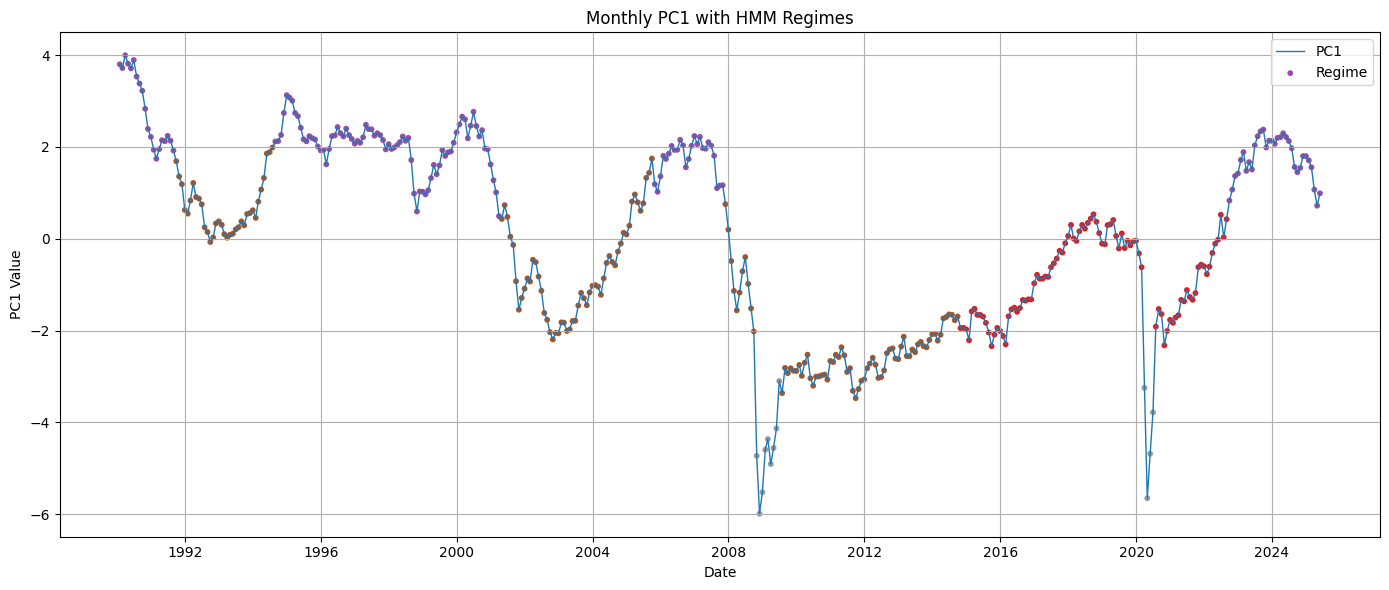

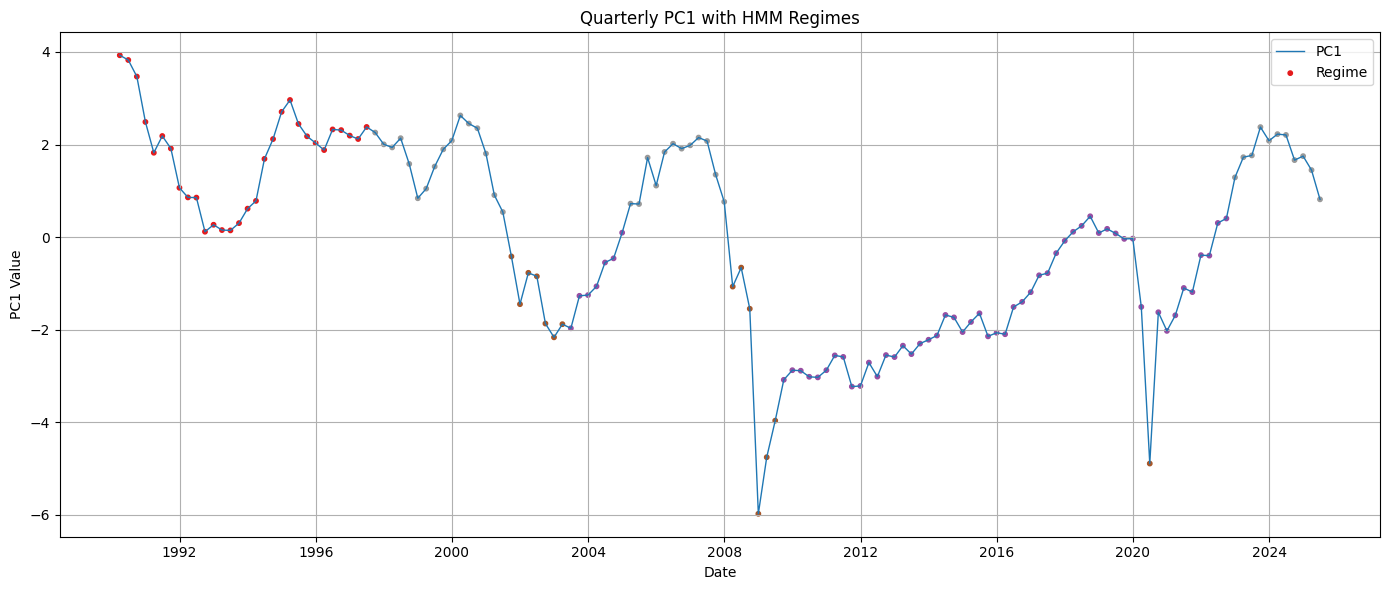

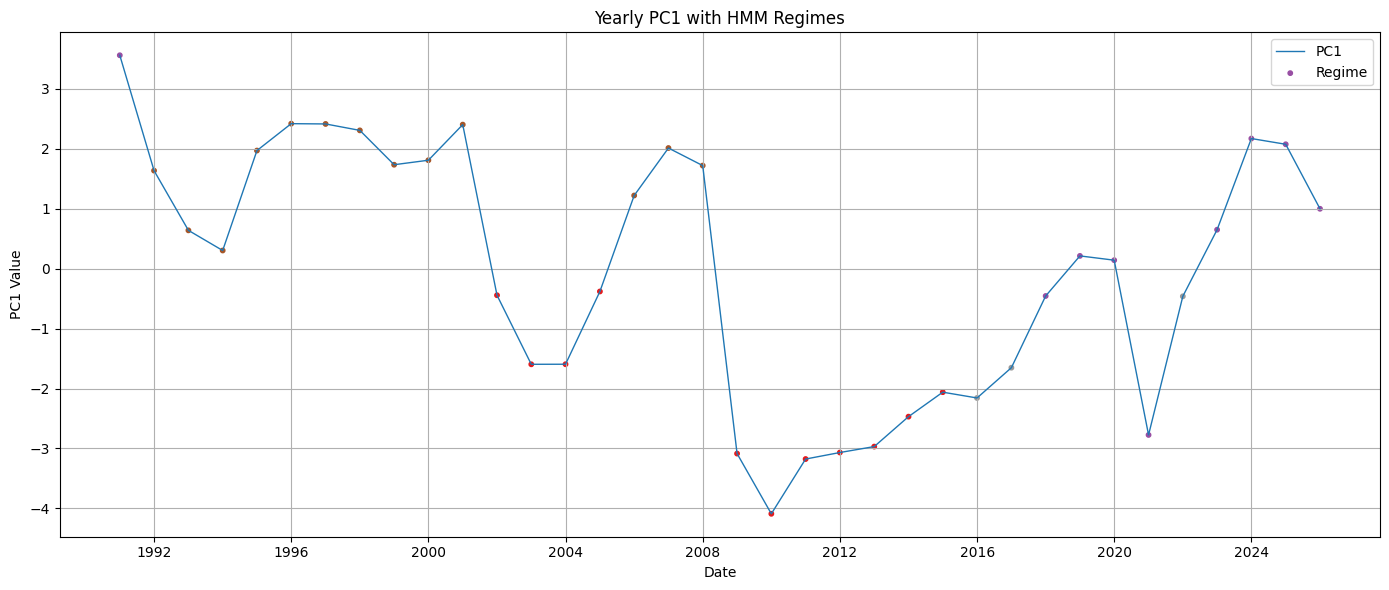

In [94]:
plot_pc1_with_regimes(pc_df, "Monthly PC1 with HMM Regimes")
plot_pc1_with_regimes(pc_df_q, "Quarterly PC1 with HMM Regimes")
plot_pc1_with_regimes(pc_df_y, "Yearly PC1 with HMM Regimes")


Compare regime interpretability

In [95]:
# Monthly

monthly_regime_means = pc_df.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print("Monthly Regime Means:")
print(monthly_regime_means.round(3))

Monthly Regime Means:
          PC1    PC2    PC3    PC4
Regime                            
0      -0.856 -1.259 -0.945 -0.009
1       2.042  0.437 -0.199  0.004
2      -1.137 -0.038  0.815 -0.051
3      -4.561  3.987 -1.186  0.655


In [96]:
# Quarterly
quarterly_regime_means = pc_df_q.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print("Quarterly Regime Means:")
print(quarterly_regime_means.round(3))

Quarterly Regime Means:
          PC1    PC2    PC3    PC4
Regime                            
0       1.805  0.563  1.288 -0.237
1      -1.485 -0.848 -0.136 -0.104
2      -2.303  1.845 -0.274  0.639
3       1.685  0.188 -0.686  0.111


In [97]:
# Yearly
yearly_regime_means = pc_df_y.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print("Yearly Regime Means:")
print(yearly_regime_means.round(3))

Yearly Regime Means:
          PC1    PC2    PC3    PC4
Regime                            
0      -2.266  0.463  0.327 -0.023
1       0.732 -0.242 -1.070  0.120
2       1.739  0.142  0.596 -0.197
3      -1.423 -1.589 -0.572  0.577
